In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import os
import random
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim


### Loading Commodities data

In [89]:
# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F
# S&P 500 : ^GSPC
# Dow Jones : ^DJI

ticker = "CL=F"
start = "2023-08-01"
end = "2024-01-01"
interval = "1d"

data = yf.download(ticker, start=start, end=end, interval=interval)
data.columns = data.columns.droplevel(1)  

date_split = "2023-10-01"
data_train = data.loc[:date_split]
data_test = data.loc[date_split:]

print(data.head())
print(data_test.head())



[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Date                                                          
2023-08-01  81.370003  82.220001  80.589996  81.730003  307859
2023-08-02  79.489998  82.430000  79.050003  82.050003  414825
2023-08-03  81.550003  81.860001  78.690002  79.769997  402641
2023-08-04  82.820000  83.239998  81.510002  81.730003  320873
2023-08-07  81.940002  83.300003  81.519997  82.820000  293036
Price           Close       High        Low       Open  Volume
Date                                                          
2023-10-02  88.820000  91.879997  88.459999  90.820000  334493
2023-10-03  89.230003  90.269997  87.760002  88.669998  350659
2023-10-04  84.220001  89.589996  84.160004  89.419998  459995
2023-10-05  82.309998  84.919998  82.150002  84.449997  465997
2023-10-06  82.790001  83.279999  81.500000  82.279999  461139


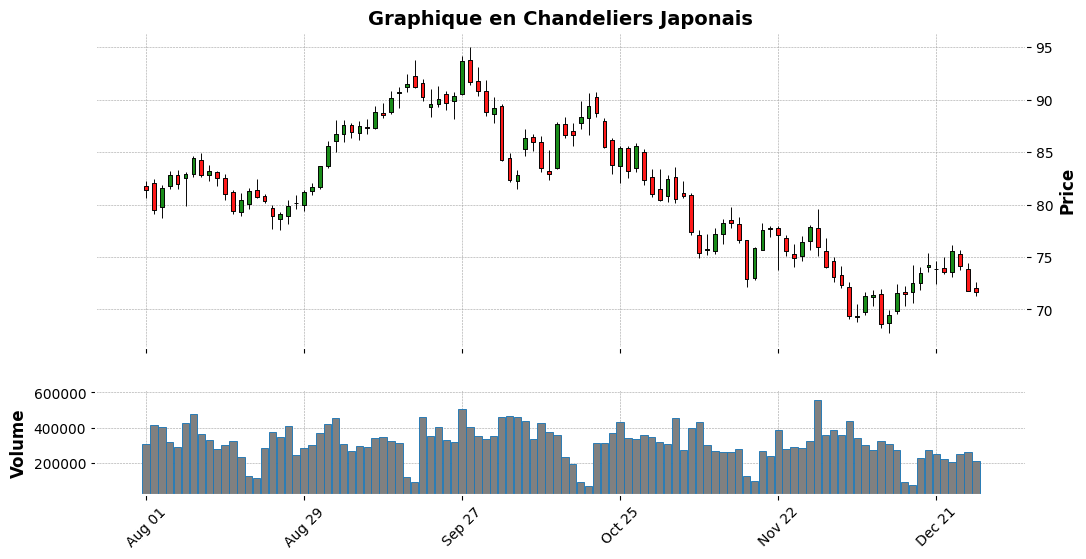

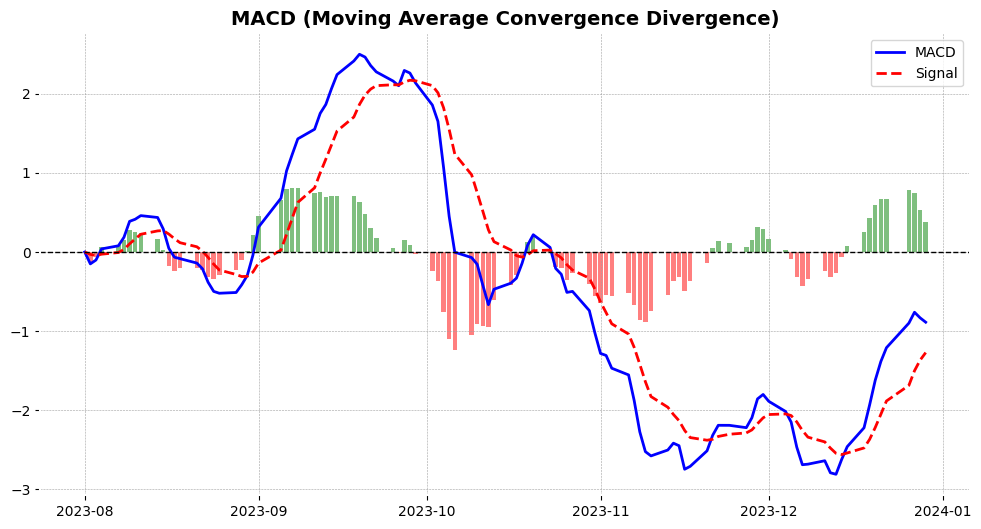

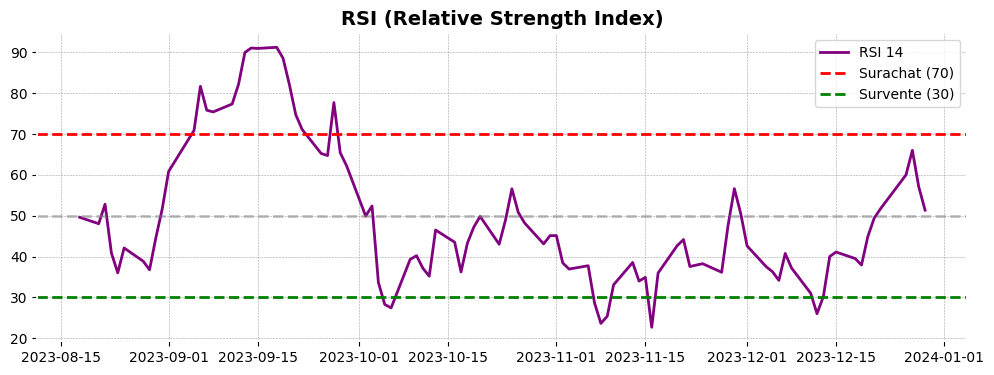

In [108]:
def plot_candlestick(data):
    """
    Affiche un graphique en chandelier avec un style moderne et épuré.
    """
    mc = mpf.make_marketcolors(up='green', down='red', wick='black', edge='black', volume='gray')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

    fig, (ax, ax_volume) = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    mpf.plot(data, type='candle', style=s, ax=ax, volume=ax_volume)
    
    ax.set_title("Graphique en Chandeliers Japonais", fontsize=14, fontweight='bold')
    
    plt.show()


def plot_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Affiche le MACD avec sa ligne de signal et son histogramme.
    """
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
 
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()

    histogram = macd - signal
 
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data.index, macd, label="MACD", color='blue', linewidth=2)
    ax.plot(data.index, signal, label="Signal", color='red', linestyle='dashed', linewidth=2)
    ax.bar(data.index, histogram, color=np.where(histogram > 0, 'green', 'red'), alpha=0.5)
    
    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Ligne horizontale zéro
    ax.set_title("MACD (Moving Average Convergence Divergence)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mplfinance as mpf

def plot_rsi(data, window=14):
    """
    Affiche le RSI (Relative Strength Index) avec une période donnée.
    """
    # Calcul du RSI
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0) 
    loss = np.where(delta < 0, -delta, 0) 

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.index, rsi, label=f'RSI {window}', color='purple', linewidth=2)
    ax.axhline(70, linestyle='dashed', color='red', label='Surachat (70)')
    ax.axhline(30, linestyle='dashed', color='green', label='Survente (30)')
    ax.axhline(50, linestyle='dashed', color='gray', alpha=0.5) 

    ax.set_title("RSI (Relative Strength Index)", fontsize=14, fontweight='bold')
    ax.legend()
    plt.show()

plot_candlestick(data)
plot_macd(data)
plot_rsi(data)


### Feature Engineering

In [111]:
def compute_rsi(series, period=14):
    """
    Calcule manuellement le RSI (Relative Strength Index).
    RSI = 100 - 100 / (1 + RS)
    RS = moyenne_pondérée_exponentielle(gains) / moyenne_pondérée_exponentielle(pertes)
    """
    delta = series.diff(1).dropna()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)

    avg_gain = gains.ewm(com=period-1, min_periods=period).mean()
    avg_loss = losses.ewm(com=period-1, min_periods=period).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    # Ré-alignement
    rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')
    return rsi

def compute_ema(series, period=12):
    """Calcule une EMA (Exponential Moving Average)."""
    return series.ewm(span=period, adjust=False).mean()

# Ajoutons RSI et EMA au DataFrame
data["RSI"] = compute_rsi(data["Close"], period=14)
data["EMA12"] = compute_ema(data["Close"], period=12)
data.dropna(inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_44220\1137775761.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi = rsi.reindex(series.index, method='bfill').fillna(method='bfill')


### Designing Environnement

In [ ]:
class Environment:
    """
    Environnement simplifié de trading sur l'or.
    - Actions discrètes : 0=stay, 1=buy, 2=sell
    - On maintient une liste des positions ouvertes, on calcule le profit
      lorsque l'on vend (2), etc.
      
    Variables description:
    - self.df : DataFrame avec les données historiques
    - self.history_t : taille de la fenêtre historique
    - self.features : liste des colonnes à utiliser
    - self.t : indice temporel actuel
    - self.done : booléen, True si la simulation est terminée
    - self.profits : gains cumulés
    - self.positions : liste des positions ouvertes (prix d'achat pas encore cloturé)
    - self.position_value : valeur actuelle des positions ouvertes. Il s'agit du gain ou la perte potentielle si l agent vendait 
                            immédiatement toutes ses positions ouvertes.
    - self.history : liste des variations de prix (Close_t - Close_t-1) sur les derniers jours (pour l'observation)
    -obs : observation actuelle (position_value, history..., Close(t), RSI(t), EMA12(t))
    -reward : récompense pour l'action précédente
    """

    def __init__(self, df, history_t=30):
        """
        :param df: DataFrame avec colonnes ['Open','High','Low','Close','RSI','EMA12']
        :param history_t: taille de la fenêtre historique
        """
        self.df = df.copy().reset_index(drop=True)
        self.history_t = history_t
        self.features = ["Close", "RSI", "EMA12"]
        self.reset()

    def reset(self):
        """
        Remet l'environnement à zéro :
         - t = 0
         - profits = 0
         - positions = []
         - position_value = 0
         - history -> [0]*history_t
        """
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0.0] * self.history_t

        return self._get_obs()

    def _get_obs(self):
        """
        Construit l'observation : 
        [position_value, history..., Close(t), RSI(t), EMA12(t)]
        """
        row = self.df.iloc[self.t]
        feats = [
            float(row["Close"]),
            float(row["RSI"]) if not pd.isnull(row["RSI"]) else 0.0,  # Correction ici
            float(row["EMA12"])
        ]
        obs = [self.position_value] + self.history + feats
        return np.array(obs, dtype=np.float32)


    def step(self, act):
        """
        Exécute l'action (0=stay,1=buy,2=sell).
        Retourne : obs, reward, done
        """
        reward = 0.0

        # Exécution
        if act == 1:
            # buy
            self.positions.append(self.df.iloc[self.t]["Close"])
        elif act == 2:
            # sell
            if len(self.positions) == 0:
                reward = -1.0  # Pénalité si on vend sans position
            else:
                # Gains cumulés
                profits = 0.0
                current_price = self.df.iloc[self.t]["Close"]
                for p in self.positions:
                    profits += (current_price - p)
                reward = profits
                self.profits += profits
                self.positions = []  # On ferme toutes les positions

        # Avancer dans le temps
        self.t += 1
        if self.t >= len(self.df) - 1:
            self.done = True

        # Calcul de la position latente
        self.position_value = 0.0
        if len(self.positions) > 0:
            current_price = self.df.iloc[self.t]["Close"]
            for p in self.positions:
                self.position_value += (current_price - p)

        # Mettre à jour l'historique
        if self.t > 0:
            price_diff = self.df.iloc[self.t]["Close"] - self.df.iloc[self.t - 1]["Close"]
        else:
            price_diff = 0.0
        self.history.pop(0)
        self.history.append(price_diff)

        # Reward final (clip)
        if reward > 0:
            reward = 1.0
        elif reward < 0:
            reward = -1.0
        else:
            reward = 0.0

        return self._get_obs(), reward, self.done

In [ ]:
class QLearningTrader:
    """
    Met en place un DQN simple en PyTorch pour entraîner un agent
    sur l'environnement GoldTradingEnv.
    """

    # --- Le réseau de neurones ---
    class QNetwork(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    def __init__(
        self,
        env: Environment,
        hidden_dim=64,
        gamma=0.95,
        lr=1e-3,
        memory_size=200,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.1,
        eps_decay=1e-3,
        update_target_freq=50,
        train_freq=10
    ):
        """
        :param env: Environnement (Environment)
        :param hidden_dim: taille des couches cachées
        :param gamma: discount factor
        :param lr: learning rate pour Adam
        :param memory_size: taille du buffer d'expérience
        :param batch_size: taille du batch
        :param eps_start, eps_min, eps_decay: pour l'epsilon-greedy
        :param update_target_freq: fréquence de copie du réseau principal vers le réseau cible
        :param train_freq: fréquence d'entraînement (en nombre de steps)
        """
        self.env = env
        sample_obs = self.env.reset()
        self.input_dim = len(sample_obs)
        self.hidden_dim = hidden_dim
        self.output_dim = 3  # stay, buy, sell -> 0, 1, 2

        self.gamma = gamma
        self.lr = lr
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.eps = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.update_target_freq = update_target_freq
        self.train_freq = train_freq

        # Réseaux
        self.policy_net = self.QNetwork(self.input_dim, hidden_dim, self.output_dim)
        self.target_net = copy.deepcopy(self.policy_net)

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Mémoire de replay : [(pobs, act, reward, obs, done), ...]
        self.memory = []
        self.total_steps = 0

    def select_action(self, obs):
        """
        Sélection d'action via epsilon-greedy.
        """
        if random.random() < self.eps:
            return random.randint(0, self.output_dim - 1)
        obs_t = torch.FloatTensor(obs).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(obs_t)
        return q_vals.argmax(dim=1).item()

    def update_epsilon(self):
        """
        Baisse epsilon linéairement jusqu'à eps_min.
        """
        if self.eps > self.eps_min:
            self.eps -= self.eps_decay
            if self.eps < self.eps_min:
                self.eps = self.eps_min

    def store_transition(self, pobs, act, reward, obs, done):
        """
        Stocke la transition dans le buffer.
        """
        self.memory.append((pobs, act, reward, obs, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    def train_step(self):
        """
        Un pas d'entraînement : on échantillonne un batch, on calcule la loss,
        et on met à jour policy_net.
        """
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        pobs, acts, rewards, obs_, dones = zip(*batch)
        pobs_t = torch.FloatTensor(pobs)
        acts_t = torch.LongTensor(acts)
        rewards_t = torch.FloatTensor(rewards)
        obs_t = torch.FloatTensor(obs_)
        dones_t = torch.BoolTensor(dones)

        # Q(s, a) du réseau policy_net
        q_vals = self.policy_net(pobs_t)
        # On ne prend que la Q-valeur de l'action réelle
        q_val = q_vals.gather(1, acts_t.unsqueeze(1)).squeeze(1)

        # Q-target : r + gamma * max(Q') (avec target_net)
        with torch.no_grad():
            q_next = self.target_net(obs_t)
            q_next_max, _ = q_next.max(dim=1)
            q_target = rewards_t + (self.gamma * q_next_max * (~dones_t))

        loss = nn.MSELoss()(q_val, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target(self):
        """
        Copie policy_net -> target_net
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, epochs=10):
        """
        Boucle d'entraînement sur un certain nombre d'épisodes (epochs).
        """
        step_max = len(self.env.df) - 1
        show_log_freq = max(1, epochs // 5)

        rewards_history = []
        losses_history = []

        start_time = time.time()
        for epoch in range(epochs):
            obs = self.env.reset()
            done = False
            ep_reward = 0.0
            ep_loss = 0.0
            step = 0

            while not done and step < step_max:
                act = self.select_action(obs)
                next_obs, reward, done = self.env.step(act)
                ep_reward += reward

                self.store_transition(obs, act, reward, next_obs, done)

                # Entraînement
                if self.total_steps % self.train_freq == 0:
                    loss_val = self.train_step()
                    ep_loss += loss_val

                # Update target network
                if self.total_steps % self.update_target_freq == 0:
                    self.update_target()

                # Décroissance de epsilon
                self.update_epsilon()

                obs = next_obs
                self.total_steps += 1
                step += 1

            rewards_history.append(ep_reward)
            losses_history.append(ep_loss)

            # Logging
            if (epoch + 1) % show_log_freq == 0:
                avg_r = np.mean(rewards_history[-show_log_freq:])
                avg_l = np.mean(losses_history[-show_log_freq:])
                elapsed = time.time() - start_time
                print(f"[Epoch {epoch+1}] Eps={self.eps:.3f}, Steps={self.total_steps}, "
                      f"Avg.Reward={avg_r:.2f}, Avg.Loss={avg_l:.3f}, Time={elapsed:.2f}s")
                start_time = time.time()

        return rewards_history, losses_history

In [ ]:
if __name__ == "__main__":
    # Séparer éventuellement en train / test si besoin
    # TODO : Augmenter le train set
    date_split = "2023-10-01"
    data_train = data.loc[:date_split]
    data_test = data.loc[date_split:]

    # Création de l'environnement
    env_train = Environment(data_train, history_t=30)
    # Instanciation du trader
    trader = QLearningTrader(
        env_train,
        hidden_dim=64,
        gamma=0.95,
        lr=1e-3,
        memory_size=500,
        batch_size=32,
        eps_start=1.0,
        eps_min=0.1,
        eps_decay=1e-3,
        update_target_freq=50,
        train_freq=10
    )
    # Entraînement sur 10 épisodes
    rewards, losses = trader.train(epochs=300)

    print("=== Entraînement terminé ===")
    print("Dernières rewards observées :", rewards[-10:])
    print("Proft final :", trader.env.profits)

[Epoch 60] Eps=0.100, Steps=2520, Avg.Reward=0.22, Avg.Loss=0.778, Time=2.00s
[Epoch 120] Eps=0.100, Steps=5040, Avg.Reward=1.25, Avg.Loss=0.782, Time=1.83s
[Epoch 180] Eps=0.100, Steps=7560, Avg.Reward=4.67, Avg.Loss=0.695, Time=1.84s
[Epoch 240] Eps=0.100, Steps=10080, Avg.Reward=5.38, Avg.Loss=0.634, Time=1.71s
[Epoch 300] Eps=0.100, Steps=12600, Avg.Reward=4.65, Avg.Loss=0.765, Time=1.68s
=== Entraînement terminé ===
Dernières rewards observées : [1.0, 7.0, 6.0, 1.0, 4.0, 4.0, 8.0, 6.0, 8.0, 7.0]
Proft final : 27.610031127929688


In [116]:
# Tester l'agent sur un environnement non vu (data_test)
env_test = Environment(data_test, history_t=30)
obs = env_test.reset()
done = False
total_profit = 0
actions_taken = []

while not done:
    action = trader.select_action(obs)  # Utilisation du modèle appris
    obs, reward, done = env_test.step(action)
    total_profit += reward
    actions_taken.append(action)

print(f"Reward total sur données test : {total_profit}")
print(f"Actions prises : {actions_taken}")
print(f"Profit final : {env_test.profits}")


Reward total sur données test : 3.0
Actions prises : [2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0]
Profit final : 26.990028381347656


In [ ]:
# TODO : implémenter un agent plus complexe, avec un réseau plus profond, et des features plus avancées.
# TODO : optimiser les hyperparamètres (grid search, etc.)
# TODO : ajouter des features (volatilité, etc.)
# TODO : ajouter une manière d'acheter plusieurs action à la fois (quantité variable)
# TODO : ajouter des frais de transaction
# TODO : Augmenter la fréquence de trading (intraday) et de points
# TODO : ajouter un stop-loss sur les positions
# TODO : ajouter un take-profit
# TODO : ajouter un système de récompense plus complexe
# TODO : ajouter une courbe de performance (capital cumulé)
# TODO : ajouter une visualisation des trades (graphique)
# TODO : ajouter une visualisation des rewards (graphique)
# TODO : ajouter une visualisation des pertes (graphique)
# TODO : ajouter un système de logging (TensorBoard, etc.)
# TODO : ajouter une sauvegarde du modèle
# TODO : ajouter un système de validation (early stopping)
# TODO : ajouter un système de rendu vidéo (Gym)
# TODO : essayer sur d'autres actifs (forex, crypto, etc.)
# TODO : essayer sur d'autres environnements (Gym)
# TODO : essayer d'autres algorithmes (PPO, DDPG, etc.)
# TODO : essayer d'autres techniques de deep learning (LSTM, etc.)
# TODO : essayer d'autres techniques de reinforcement learning (DQN, etc.)
# TODO : essayer d'autres techniques de trading (pairs trading, etc.)
# TODO : CNN dont la loss est f(xi) - somme des différences croissantes
# TODO : Rajouter le volume dans les features
# TODO : Rajouter des features de volatilité
# TODO : Rajouter des features de momentum
# TODO : Rajouter des features de tendance
# TODO : Rajouter des features de support et résistance
# TODO : Rajouter des features de gap
# TODO : Rajouter des features de chandeliers japonais
# TODO : Rajouter des features de pattern recognition
# TODO : Rajouter des features de news sentiment
# TODO : Rajouter des features de sentiment analysis
# TODO : Rajouter des features de macroéconomie
# TODO : Rajouter des features de microéconomie
# TODO : Rajouter des features de taux d'intérêt
